In [25]:
!pwd

import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb

import sys 
sys.path.append('../')
import src.model.feature_cleaning as feature_cleaning

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


#sklearn models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#sklearn other
#import graphviz 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, log_loss, accuracy_score, roc_auc_score, auc, roc_curve
#from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence



/Users/fabio/galv/capstone/notebooks


In [26]:
df, fieldofdegree_df, SOCP_labels, schl_labels, major_majors, NAICSP_labels_df, MAJ_NAICSP_labels_df = feature_cleaning.load_dfs()

youngemp_df = feature_cleaning.clean_that_target(df, SOCP_labels)
youngemp_df = feature_cleaning.single_occ_target(youngemp_df)
freewill_df = feature_cleaning.create_freewill_df(youngemp_df, fieldofdegree_df, schl_labels, major_majors)

../src/model/feature_cleaning.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  SOCPdf = df.dropna(axis='index', subset=['SOCP'])[df.SOCP != '999920']


Number of employed people: 218454
Percent employed people: 0.5785711448056677
Number of young employed people: 77406
Percent young employed people(out of all PUMS): 0.20500827650135733
Number of emp cats: 23
Number of degree fields present (max 173): 173


../src/model/feature_cleaning.py:252: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  freewill_df['PUMA_cat'] = freewill_df.PUMA.astype(str)
../src/model/feature_cleaning.py:264: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  freewill_df['COW_labels'] = freewill_df.COW.map(COW_df)
/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

before dummies:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77406 entries, 0 to 77405
Data columns (total 26 columns):
SERIALNO            77406 non-null int64
SOCP                77406 non-null object
MAJ_SOCP            77406 non-null object
MAJ_SOCP_labels     77406 non-null object
FOD1P               77406 non-null object
MAJ_SOCP_15         77406 non-null int64
FOD2P               77406 non-null object
FOD1P_labels        77406 non-null object
FOD1P_MAJ_labels    77406 non-null object
FOD2P_labels        77406 non-null object
SCHL                77406 non-null object
SCHL_labels         77406 non-null object
PUMA                77406 non-null int64
COW                 77406 non-null float64
ENG                 77406 non-null float64
MARHT               77406 non-null float64
MSP                 77406 non-null float64
RELP                77406 non-null int64
FMILSP              77406 non-null int64
PUMA_cat            77406 non-null object
COW_labels          77406 non-null o

In [27]:
# split the data, choosing only edu cols
X = freewill_df.drop(columns=['SERIALNO', 'SOCP','MAJ_SOCP','MAJ_SOCP_labels','MAJ_SOCP_15', 
                'FOD1P_labels','FOD1P_MAJ_labels','FOD2P_labels','SCHL','SCHL_labels', 'COW_labels',
                        'ENG_labels', 'MARHT_labels', 'MSP_labels', 'RELP_labels', 'FMILSP_labels'])
y = freewill_df.loc[:,'MAJ_SOCP_15']

y.tail(10)

77396    0
77397    0
77398    0
77399    0
77400    0
77401    0
77402    0
77403    0
77404    0
77405    0
Name: MAJ_SOCP_15, dtype: int64

In [33]:
X_train.head()

,PUMA,COW__Employee(for-profit),COW__Employee(non-profit),"COW__Family business, unpaid",COW__Federal gov employee,COW__Local gov employee,COW__Self-employed(inc),COW__Self-employed(not inc),COW__State govemployee,ENG__Native,ENG__Not at all,ENG__Not well,ENG__Very well,ENG__Well,FMILSP__No,FMILSP__Yes,"FOD1P_MAJ__Agriculture, agriculture operations, and related sciences",FOD1P_MAJ__Architecture and related services,"FOD1P_MAJ__Area, ethnic, cultural, gender, and group studies",FOD1P_MAJ__Biological and biomedical sciences,"FOD1P_MAJ__Business, management, marketing, and related support services","FOD1P_MAJ__Communication, journalism, and related programs",FOD1P_MAJ__Communications technologies/technicians and support services,FOD1P_MAJ__Computer and information sciences and support services,FOD1P_MAJ__Construction trades,FOD1P_MAJ__Education,FOD1P_MAJ__Engineering,FOD1P_MAJ__Engineering technologies and engineering-related fields,FOD1P_MAJ__English language and literature/letters,FOD1P_MAJ__Family and consumer sciences/human sciences,"FOD1P_MAJ__Foreign languages, literatures, and linguistics",FOD1P_MAJ__Health professions and related programs,FOD1P_MAJ__History,"FOD1P_MAJ__Homeland security, law enforcement, firefighting and related protective services",FOD1P_MAJ__Legal professions and studies,"FOD1P_MAJ__Liberal arts and sciences, general studies and humanities",FOD1P_MAJ__Library science,FOD1P_MAJ__Mathematics and statistics,FOD1P_MAJ__Mechanic and repair technologies/technicians,"FOD1P_MAJ__Military science, leadership and operational art",FOD1P_MAJ__Multi/interdisciplinary studies,FOD1P_MAJ__Natural resources and conservation,FOD1P_MAJ__No major,"FOD1P_MAJ__Parks, recreation, leisure, and fitness studies",FOD1P_MAJ__Personal and culinary services,FOD1P_MAJ__Philosophy and religious studies,FOD1P_MAJ__Physical sciences,FOD1P_MAJ__Psychology,FOD1P_MAJ__Public administration and social service professions,FOD1P_MAJ__Science technologies/technicians,FOD1P_MAJ__Social sciences,FOD1P_MAJ__Theology and religious vocations,FOD1P_MAJ__Transportation and materials moving,FOD1P_MAJ__Visual and performing arts,FOD1P__Accounting,FOD1P__Actuarial Science,FOD1P__Advertising And Public Relations,FOD1P__Aerospace Engineering,FOD1P__Agricultural Economics,FOD1P__Agriculture Production And Management,FOD1P__Animal Sciences,FOD1P__Anthropology And Archeology,FOD1P__Applied Mathematics,FOD1P__Architectural Engineering,FOD1P__Architecture,FOD1P__Area Ethnic And Civilization Studies,FOD1P__Art And Music Education,FOD1P__Art History And Criticism,FOD1P__Astronomy And Astrophysics,FOD1P__Atmospheric Sciences And Meteorology,FOD1P__Biochemical Sciences,FOD1P__Biological Engineering,FOD1P__Biology,FOD1P__Biomedical Engineering,FOD1P__Botany,FOD1P__Business Economics,FOD1P__Business Management And Administration,FOD1P__Chemical Engineering,FOD1P__Chemistry,FOD1P__Civil Engineering,FOD1P__Clinical Psychology,FOD1P__Cognitive Science And Biopsychology,FOD1P__Commercial Art And Graphic Design,FOD1P__Communication Disorders Sciences And Services,FOD1P__Communication Technologies,FOD1P__Communications,FOD1P__Community And Public Health,FOD1P__Composition And Rhetoric,FOD1P__Computer Administration Management And Security,FOD1P__Computer And Information Systems,FOD1P__Computer Engineering,FOD1P__Computer Networking And Telecommunications,FOD1P__Computer Programming And Data Processing,FOD1P__Computer Science,FOD1P__Construction Services,FOD1P__Cosmetology Services And Culinary Arts,FOD1P__Counseling Psychology,FOD1P__Court Reporting,FOD1P__Criminal Justice And Fire Protection,FOD1P__Criminology,FOD1P__Drama And Theater Arts,FOD1P__Early Childhood Education,FOD1P__Ecology,FOD1P__Economics,FOD1P__Educational Administration And Supervision,FOD1P__Educational Psychology,FOD1P__Electrical Engineering,FOD1P__Electrical Engineering Technology,"FOD1P__Electrical, Mechanical, And Precision Technologies And Production",FOD1P__Elementary Education,FOD1P__Engineerin

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)

In [30]:

# model pipelines
#-----------------------------------
#-------------linear
pipe_lr = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_lr_l2 = Pipeline([('scl', StandardScaler()),
            ('clf', LogisticRegression(random_state=42))])

pipe_sgd = Pipeline([('scl', StandardScaler()),
            ('clf', SGDClassifier(random_state=42))])


#-------------trees
pipe_dt = Pipeline([('clf', DecisionTreeClassifier(random_state=42))])

pipe_rf = Pipeline([('clf', RandomForestClassifier(random_state=42))])

pipe_rf_scl = Pipeline([('scl', StandardScaler()),
            ('clf', RandomForestClassifier(random_state=42))])

pipe_gb = Pipeline([('clf', GradientBoostingClassifier(random_state=42))])


#-------------SVM
pipe_svm = Pipeline([('scl', StandardScaler()),
            ('clf', SVC(random_state=42))])


#-------------KNN
pipe_knn = Pipeline([('clf', KNeighborsClassifier())])

pipe_knn_scl = Pipeline([('scl', StandardScaler()),
            ('clf', KNeighborsClassifier())])

#-----------------------------------

#-------------XGB
pipe_xgb = Pipeline([('clf', xgb.XGBClassifier())])
#-----------------------------------


# grid search params
param_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
param_range_fl = [1.0, 0.5, 0.1]
max_depth = [10,100,1000,10000]
max_depth2 = [10,100,1000]
alpha_range = [.1, .001, .00001, .000001]
gamma_range = [.1, 1, 10]

#-------------linear
grid_params_lr = [{'clf__penalty': ['l1'],
        'clf__C': param_range_fl,
        'clf__solver': ['liblinear', ],  #,'saga'
        #'clf__multi_class': ['ovr', 'multinomial', 'auto'],
        'clf__class_weight': [None, 'balanced']}] 

grid_params_lr_l2 = [{'clf__penalty': ['l2'],
        'clf__C': param_range_fl,
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear'],  #, 'sag'
        #'clf__multi_class': ['ovr', 'multinomial', 'auto'],
        'clf__class_weight': [None, 'balanced']}]

grid_params_sgd = [{'clf__loss': ['hinge', 'log', 'perceptron'],
        'clf__alpha': alpha_range,
        'clf__penalty': ['l1', 'l2', 'elasticnet'],
        'clf__class_weight': [None, 'balanced']}] 

#-------------trees
grid_params_dt = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': max_depth,
        'clf__min_samples_split': param_range[1:],
        'clf__class_weight': [None, 'balanced']}]

grid_params_rf = [{}]

# 'clf__criterion': ['entropy', 'gini'],
#         'clf__min_samples_leaf': [1, 2, 4],
#         'clf__max_depth': [10, 100, None],
#         'clf__min_samples_split': [2, 10],
#         #'clf__class_weight': [None],
#         'clf__n_estimators':[200, 500]

grid_params_gb = [{}]

# 'clf__loss': ['deviance', 'exponential'],
#         'clf__learning_rate': alpha_range,
#         'clf__n_estimators': max_depth2,
#         'clf__subsample': param_range_fl

#-------------SVM
grid_params_svm = [{'clf__kernel': ['linear', 'rbf', 'poly'],
        'clf__degree': param_range[1:],
        'clf__gamma': gamma_range,
        'clf__C': gamma_range,
        'clf__class_weight': [None, 'balanced']}]

#-------------KNN
grid_params_knn = [{'clf__n_neighbors': param_range}]

#-------------XGB

grid_params_xgb = [{}]

# #'clf__n_estimators': max_depth2,
#                    'clf__max_depth': max_depth,
#                    'clf__learning_rate':gamma_range

#--------------------------------------------------------------

# Construct grid searches
jobs = -1
verbose = 2

#-------------linear
gs_lr = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose) 

gs_lr_l2 = GridSearchCV(estimator=pipe_lr_l2,
            param_grid=grid_params_lr_l2,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

gs_sgd = GridSearchCV(estimator=pipe_sgd,
            param_grid=grid_params_sgd,
            scoring='f1_micro',
            cv=10,
            verbose=verbose)


#-------------trees    
gs_dt = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_dt,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=grid_params_rf,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_rf_scl = GridSearchCV(estimator=pipe_rf_scl,
            param_grid=grid_params_rf,
            scoring='f1_micro',
            cv=10, 
            n_jobs=jobs,
            verbose=verbose)

gs_gb = GridSearchCV(estimator=pipe_gb,
            param_grid=grid_params_gb,
            scoring='f1_micro',
            cv=10, 
            verbose=verbose)

#-------------SVM

gs_svm = GridSearchCV(estimator=pipe_svm,
            param_grid=grid_params_svm,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

#-------------KNN
gs_knn = GridSearchCV(estimator=pipe_knn,
            param_grid=grid_params_knn,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

gs_knn_scl = GridSearchCV(estimator=pipe_knn_scl,
            param_grid=grid_params_knn,
            scoring='f1_micro',
            cv=10,
            n_jobs=jobs,
            verbose=verbose)

#-------------XGB
gs_xgb = GridSearchCV(estimator=pipe_xgb,
            param_grid=grid_params_xgb,
            scoring='f1_micro',
            cv=10, 
            verbose=verbose)

#---------------------------------------------------------------------

# List of pipelines for ease of iteration
grids = [ gs_rf]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0:'rf'}

# Fit the grid search objects
print('Performing model optimizations...')
best_f1_micro = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs = gs.fit(X_train, y_train)

    # Best params
    print('Best params: %s' % gs.best_params_)

    # Best training data f1
    print('Best training f1: %.3f' % gs.best_score_)

    # Predict on test data with best params
    y_pred = gs.predict(X_test)

    #accuracy
    print('test accuracy {}:'.format( accuracy_score(y_test, y_pred)))

    # Test data accuracy of model with best params
    print('Test set f1 score for best params: %.3f ' % f1_score(y_test, y_pred))

    # Track best (highest test f1) model
    if f1_score(y_test, y_pred) > best_f1_micro:
        best_f1_micro = f1_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
print('\nClassifier with best test set f1: %s' % grid_dict[best_clf])

# Save best grid search pipeline to file
dump_file = 'freewill_tuned_rf_occ_15_leakage_removed.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print('\nSaved %s grid search pipeline to file: %s' % (grid_dict[best_clf], dump_file))

Performing model optimizations...

Estimator: rf
Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ................................................. , total=   7.9s
[CV] ................................................. , total=   8.0s
[CV] .................................

[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    9.4s remaining:    9.4s


[CV] ................................................. , total=   8.0s
[CV] ................................................. , total=   8.3s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    9.7s finished


Best params: {}
Best training f1: 0.966
test accuracy 0.9659374730858669:
test auc 0.6337293799249618:
Test set f1 score for best params: 0.371 

Classifier with best test set f1: rf

Saved rf grid search pipeline to file: freewill_tuned_rf_occ_15_leakage_removed.pkl


In [ ]:
#dont have time to tune this, going to unpickle and use the one with leakage for the demo

In [10]:
importances = gs.best_estimator_.named_steps["clf"].feature_importances_ 
indices = np.argsort(importances)[::-1][0:20]

Text(0.5,1,'Feature Importances on CS Occupation Using Random Forest')

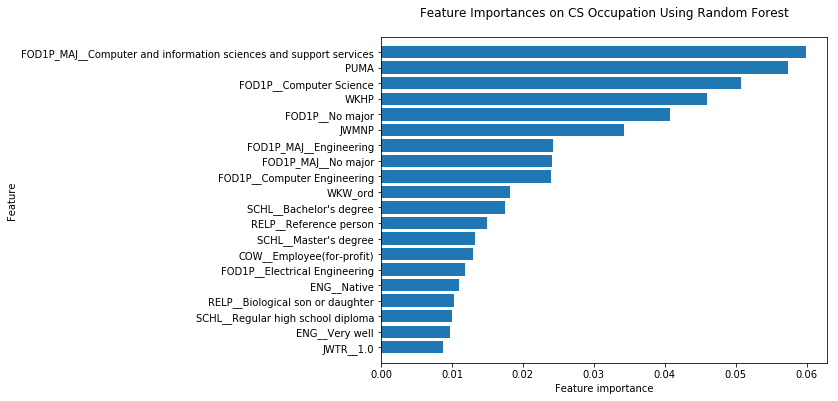

In [11]:
def plot_feature_importances(model):
    plt.figure(figsize=(8,6))
    n_features = 20
    plt.barh(range(n_features), importances[indices], align='center')
    plt.yticks(np.arange(n_features), [X.columns[i] for i in indices])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(gs.best_estimator_.named_steps["clf"])
plt.gca().invert_yaxis()
plt.title("Feature Importances on CS Occupation Using Random Forest", pad=20)

Text(0.5,1,'Feature Importances on CS Occupation Using Random Forest')

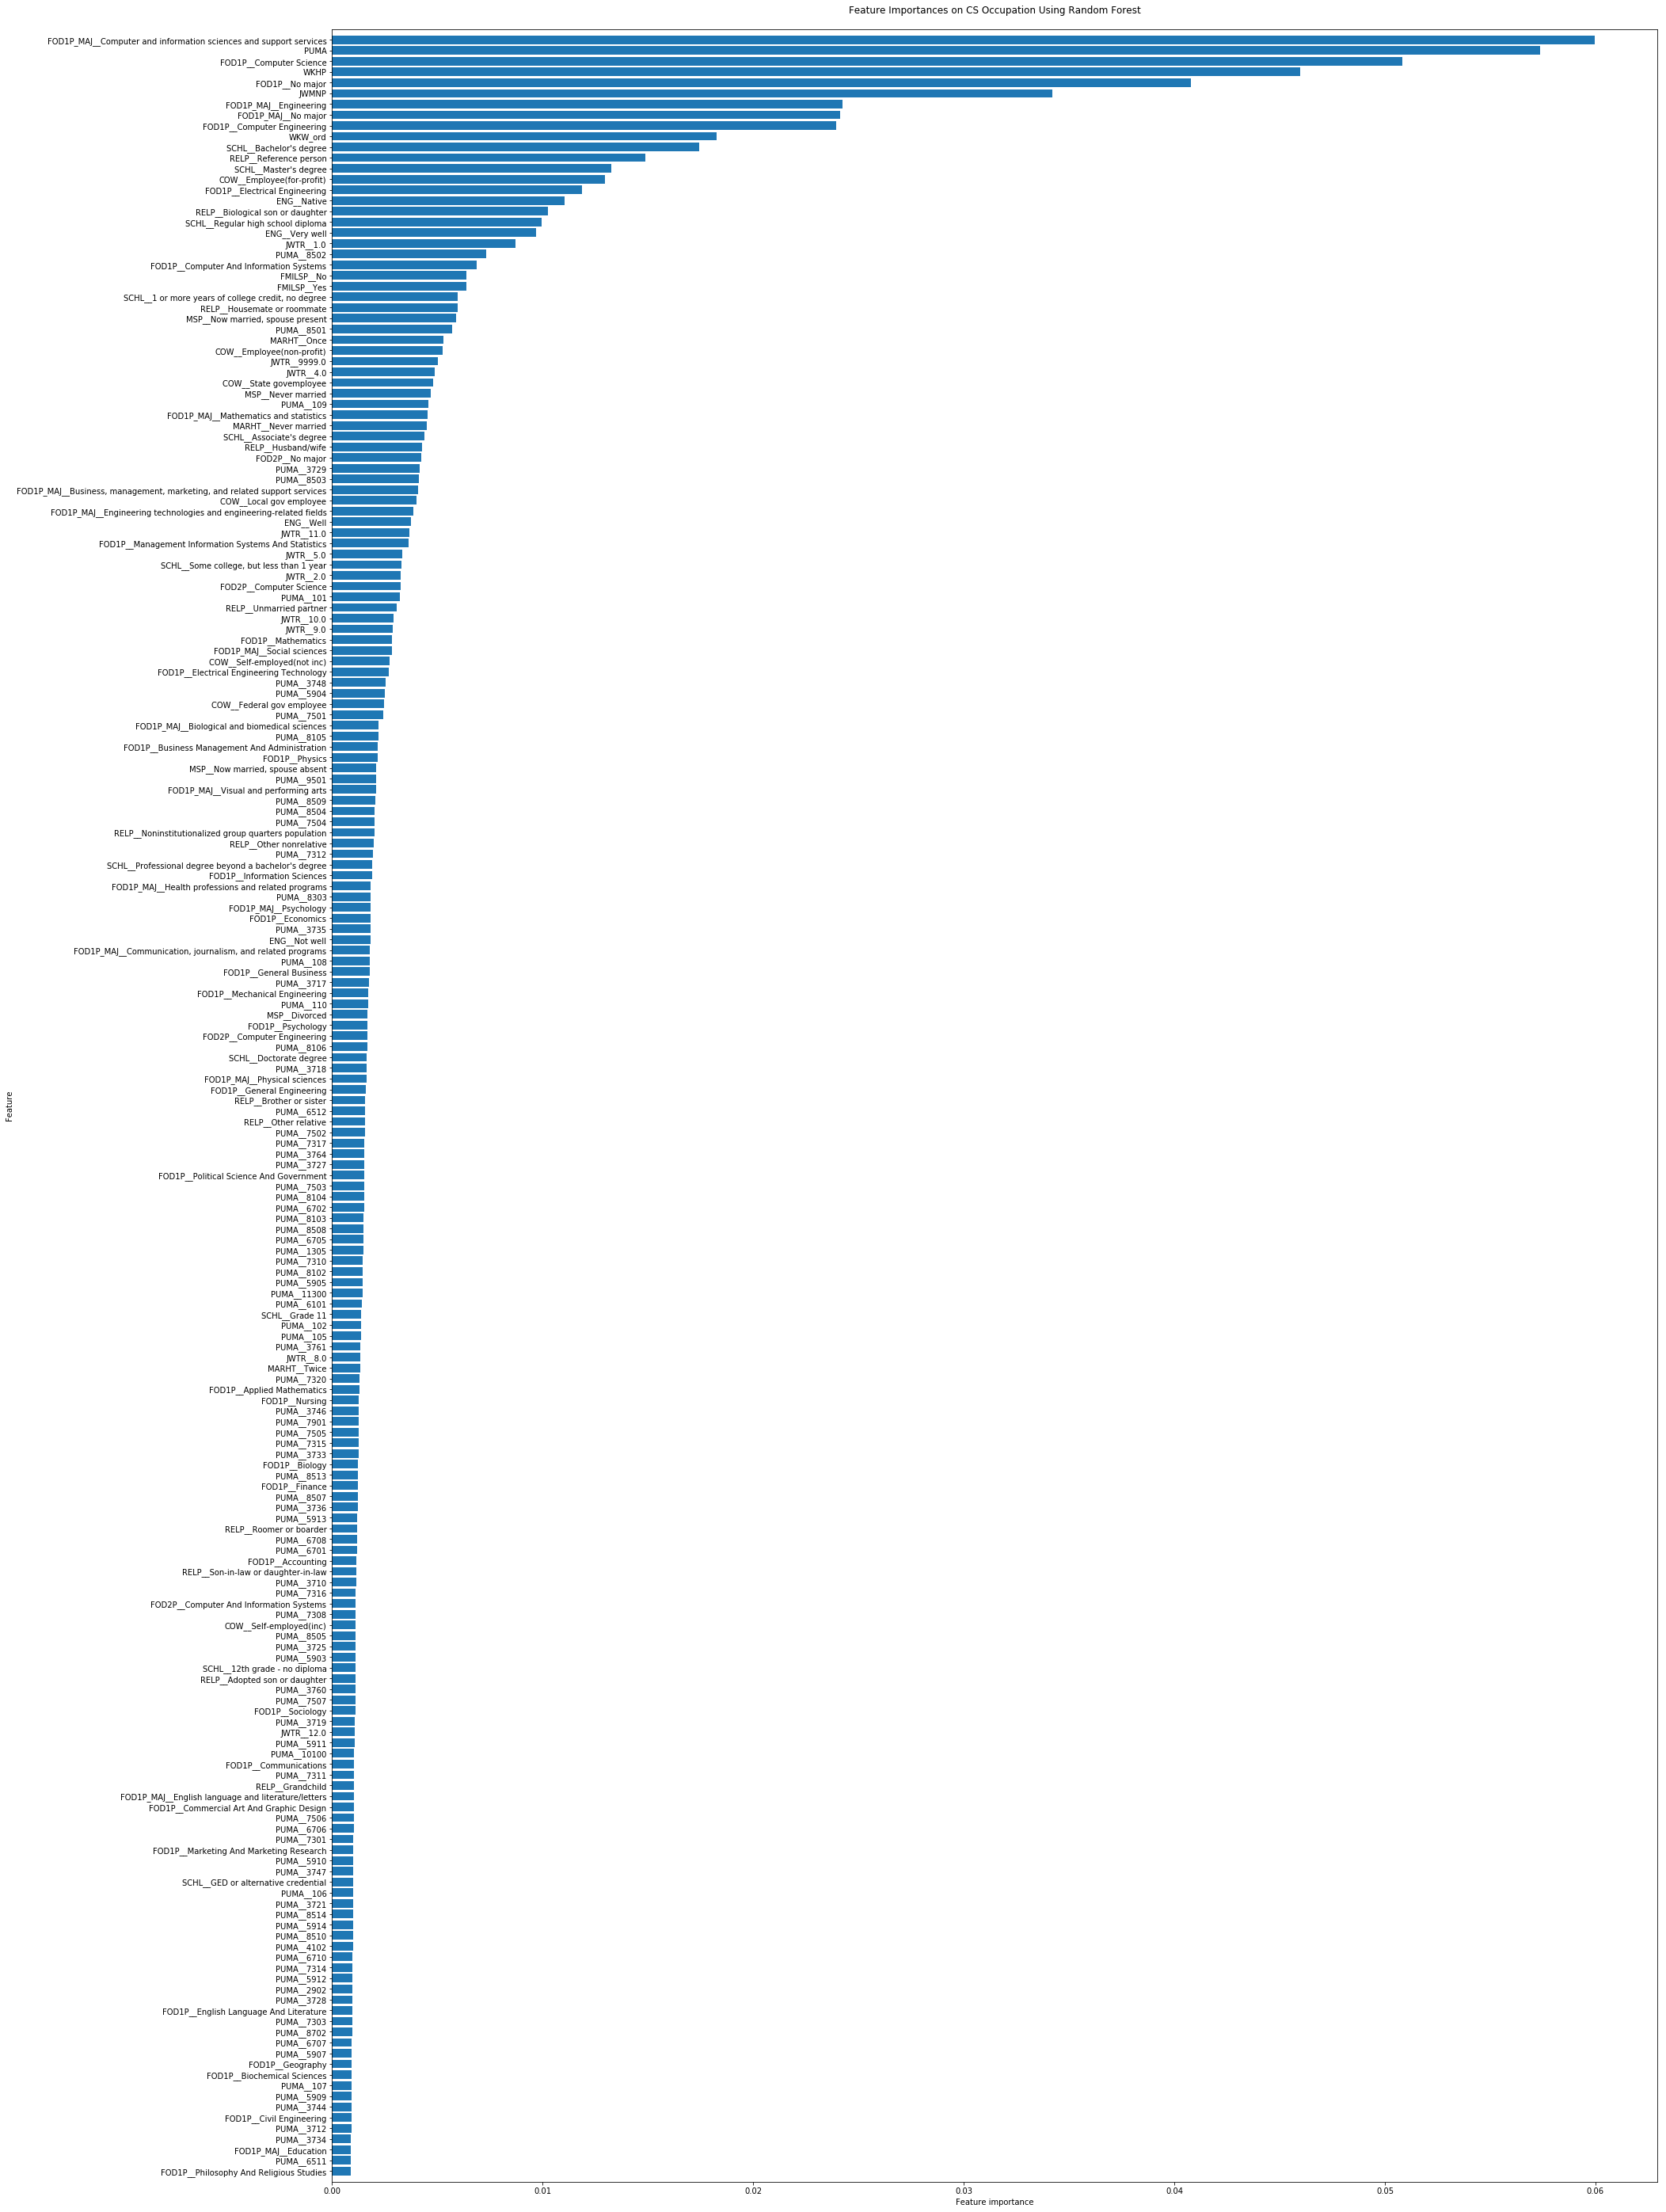

In [15]:
importances = gs.best_estimator_.named_steps["clf"].feature_importances_ 
indices = np.argsort(importances)[::-1][0:200]
def plot_feature_importances(model):
    plt.figure(figsize=(30,50))
    n_features = 200
    plt.barh(range(n_features), importances[indices], align='center')
    plt.yticks(np.arange(n_features), [X.columns[i] for i in indices])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(gs.best_estimator_.named_steps["clf"])
plt.gca().invert_yaxis()
plt.title("Feature Importances on CS Occupation Using Random Forest", pad=20)

In [58]:
confusion_matrix(y_test, y_pred)

array([[22198,   178],
       [  613,   233]])

In [62]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[22198   178]
 [  613   233]]


NameError: name 'class_names' is not defined

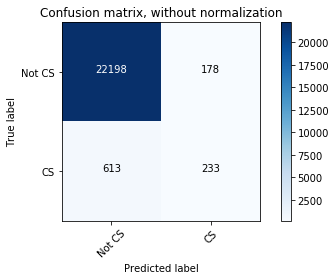

<Figure size 432x288 with 0 Axes>

In [64]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Not CS', 'CS'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

In [39]:
Me_df = X.copy().drop(Me_df.index, inplace=True)

In [48]:
Me_df.drop(Me_df.index, inplace=True)

In [51]:
Me2 = pd.DataFrame([[6703,1,1,1,1,1,1,1,1]], columns=['PUMA', 'COW__Self-employed(not inc)', 'Eng_Native',
                                               'FMILSP__No','FOD1P_MAJ__Business, management, marketing, and related support services',
                                               'FOD1P__Business Management And Administration', 
                                            'PUMA_6703', 'RELP__Unmarried partner', "SCHL__Bachelor's degree"])

In [55]:
Me_df = Me_df.append(Me2).fillna(0)






/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [57]:
X.head()

,PUMA,COW__Employee(for-profit),COW__Employee(non-profit),"COW__Family business, unpaid",COW__Federal gov employee,COW__Local gov employee,COW__Self-employed(inc),COW__Self-employed(not inc),COW__State govemployee,ENG__Native,ENG__Not at all,ENG__Not well,ENG__Very well,ENG__Well,FMILSP__No,FMILSP__Yes,"FOD1P_MAJ__Agriculture, agriculture operations, and related sciences",FOD1P_MAJ__Architecture and related services,"FOD1P_MAJ__Area, ethnic, cultural, gender, and group studies",FOD1P_MAJ__Biological and biomedical sciences,"FOD1P_MAJ__Business, management, marketing, and related support services","FOD1P_MAJ__Communication, journalism, and related programs",FOD1P_MAJ__Communications technologies/technicians and support services,FOD1P_MAJ__Computer and information sciences and support services,FOD1P_MAJ__Construction trades,FOD1P_MAJ__Education,FOD1P_MAJ__Engineering,FOD1P_MAJ__Engineering technologies and engineering-related fields,FOD1P_MAJ__English language and literature/letters,FOD1P_MAJ__Family and consumer sciences/human sciences,"FOD1P_MAJ__Foreign languages, literatures, and linguistics",FOD1P_MAJ__Health professions and related programs,FOD1P_MAJ__History,"FOD1P_MAJ__Homeland security, law enforcement, firefighting and related protective services",FOD1P_MAJ__Legal professions and studies,"FOD1P_MAJ__Liberal arts and sciences, general studies and humanities",FOD1P_MAJ__Library science,FOD1P_MAJ__Mathematics and statistics,FOD1P_MAJ__Mechanic and repair technologies/technicians,"FOD1P_MAJ__Military science, leadership and operational art",FOD1P_MAJ__Multi/interdisciplinary studies,FOD1P_MAJ__Natural resources and conservation,FOD1P_MAJ__No major,"FOD1P_MAJ__Parks, recreation, leisure, and fitness studies",FOD1P_MAJ__Personal and culinary services,FOD1P_MAJ__Philosophy and religious studies,FOD1P_MAJ__Physical sciences,FOD1P_MAJ__Psychology,FOD1P_MAJ__Public administration and social service professions,FOD1P_MAJ__Science technologies/technicians,FOD1P_MAJ__Social sciences,FOD1P_MAJ__Theology and religious vocations,FOD1P_MAJ__Transportation and materials moving,FOD1P_MAJ__Visual and performing arts,FOD1P__Accounting,FOD1P__Actuarial Science,FOD1P__Advertising And Public Relations,FOD1P__Aerospace Engineering,FOD1P__Agricultural Economics,FOD1P__Agriculture Production And Management,FOD1P__Animal Sciences,FOD1P__Anthropology And Archeology,FOD1P__Applied Mathematics,FOD1P__Architectural Engineering,FOD1P__Architecture,FOD1P__Area Ethnic And Civilization Studies,FOD1P__Art And Music Education,FOD1P__Art History And Criticism,FOD1P__Astronomy And Astrophysics,FOD1P__Atmospheric Sciences And Meteorology,FOD1P__Biochemical Sciences,FOD1P__Biological Engineering,FOD1P__Biology,FOD1P__Biomedical Engineering,FOD1P__Botany,FOD1P__Business Economics,FOD1P__Business Management And Administration,FOD1P__Chemical Engineering,FOD1P__Chemistry,FOD1P__Civil Engineering,FOD1P__Clinical Psychology,FOD1P__Cognitive Science And Biopsychology,FOD1P__Commercial Art And Graphic Design,FOD1P__Communication Disorders Sciences And Services,FOD1P__Communication Technologies,FOD1P__Communications,FOD1P__Community And Public Health,FOD1P__Composition And Rhetoric,FOD1P__Computer Administration Management And Security,FOD1P__Computer And Information Systems,FOD1P__Computer Engineering,FOD1P__Computer Networking And Telecommunications,FOD1P__Computer Programming And Data Processing,FOD1P__Computer Science,FOD1P__Construction Services,FOD1P__Cosmetology Services And Culinary Arts,FOD1P__Counseling Psychology,FOD1P__Court Reporting,FOD1P__Criminal Justice And Fire Protection,FOD1P__Criminology,FOD1P__Drama And Theater Arts,FOD1P__Early Childhood Education,FOD1P__Ecology,FOD1P__Economics,FOD1P__Educational Administration And Supervision,FOD1P__Educational Psychology,FOD1P__Electrical Engineering,FOD1P__Electrical Engineering Technology,"FOD1P__Electrical, Mechanical, And Precision Technologies And Production",FOD1P__Elementary Education,FOD1P__Engineerin

In [56]:
#predict myself
gs.best_estimator_.named_steps["clf"].predict_proba(Me_df)

ValueError: Number of features of the model must match the input. Model n_features is 696 and input n_features is 698 